(339, 2)
baseline_error =  0.00185
corrected_error =  0.0017


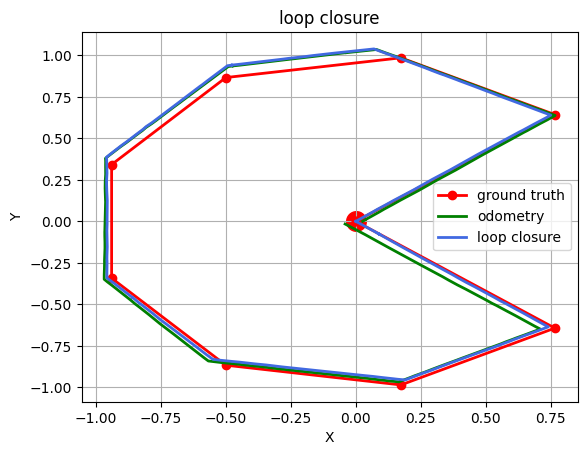

In [119]:
import numpy
import matplotlib.pyplot as plt


def encoder_to_cartesian(dDistance, dTheta, x0 = 0, y0 = 0, theta0 = 0):
    n_points = dDistance.shape[0]

    result  = numpy.zeros((n_points, 2))
   
    x       = float(x0)
    y       = float(y0)
    theta   = float(theta0) 

    for n in range(n_points):
        x     = x + dDistance[n]*numpy.cos(dTheta[n])
        y     = y + dDistance[n]*numpy.sin(dTheta[n])
        theta = theta + dTheta[n]

        result[n, 0] = x
        result[n, 1] = y

    return result



def robot_motion(n_points, distance_uncertainty, theta_uncertainty,  velocity = 0.02):
    x     = 0
    y     = 0
    theta = 0

    #key_points = 2.0*numpy.random.rand(n_points, 2) - 1.0
    key_points = numpy.zeros((n_points, 2))

    for i in range(n_points):
        phi = i*numpy.pi*2/(n_points-1)

        key_points[i, 0] = numpy.cos(phi)
        key_points[i, 1] = numpy.sin(phi)


    key_points[0, :]  = 0
    key_points[-1, :] = 0

    # robot path result
    robot_path = []

    # encoder simulation result
    dDistance = []
    dTheta    = []

    for i in range(n_points):

        kp = key_points[i]

        for n in range(500):
            x_target = kp[0]
            y_target = kp[1]

            d = (y_target - y)**2 + (x_target - x)**2

            dtheta = numpy.arctan2(y_target - y, x_target - x)
            x = x + velocity*numpy.cos(dtheta)
            y = y + velocity*numpy.sin(dtheta)
            theta = theta + dtheta
          
            robot_path.append((x, y))
              
            dDistance.append(velocity + distance_uncertainty*numpy.random.randn())
            dTheta.append(dtheta + theta_uncertainty*numpy.random.randn())

            if d < 0.001:
                break

    robot_path = numpy.array(robot_path)

    dDistance = numpy.array(dDistance)
    dTheta = numpy.array(dTheta)


    return key_points, robot_path, dDistance, dTheta


def loop_closure(dDistance, dTheta, distance_uncertainty, theta_uncertainty, x0 = 0, y0 = 0, theta0 = 0):
   
    n_points = dDistance.shape[0]

    result  = numpy.zeros((n_points, 2))


    accumulated_distance_uncertainty = numpy.zeros((n_points, ))
    accumulated_theta_uncertainty    = numpy.zeros((n_points, ))
   
    x       = numpy.zeros((n_points, ))
    y       = numpy.zeros((n_points, ))
    theta   = numpy.zeros((n_points, ))

    x[0] = x0
    y[0] = y0
    theta[0] = theta0

    for n in range(1, n_points):
        x[n]  = x[n-1] + dDistance[n]*numpy.cos(dTheta[n])
        y[n]  = y[n-1] + dDistance[n]*numpy.sin(dTheta[n])
        theta[n] = theta[n-1] + dTheta[n]

        # accumulate uncertainties
        accumulated_distance_uncertainty[n] = accumulated_distance_uncertainty[n-1] + distance_uncertainty
        accumulated_theta_uncertainty[n]    = accumulated_theta_uncertainty[n-1]    + theta_uncertainty
    

    # Normalize the accumulated uncertainties
    distance_weights = accumulated_distance_uncertainty / accumulated_distance_uncertainty[-1]
    theta_weights    = accumulated_theta_uncertainty / accumulated_theta_uncertainty[-1]
    
    # Calculate the drift
    drift_x = x[-1] - x[0]
    drift_y = y[-1] - y[0]
    drift_theta = theta[-1] - theta[0]
    
    # Apply non-uniform correction based on the respective weights
    x_corrected = x - distance_weights * drift_x
    y_corrected = y - distance_weights * drift_y
    theta_corrected = theta - theta_weights * drift_theta


    result = numpy.vstack([x_corrected, y_corrected]).T

    print(result.shape)

    return result




distance_uncertainty = 0.01
theta_uncertainty    = 0.02

key_points, robot_path, dDistance, dTheta = robot_motion(10, distance_uncertainty, theta_uncertainty)

encoder_position = encoder_to_cartesian(dDistance, dTheta)

corrected_position = loop_closure(dDistance, dTheta, distance_uncertainty, theta_uncertainty)


baseline_error = ((encoder_position - robot_path)**2).mean()
print("baseline_error = ", round(baseline_error, 5))

corrected_error = ((corrected_position - robot_path)**2).mean()
print("corrected_error = ", round(corrected_error, 5))

plt.plot(key_points[:, 0], key_points[:, 1],  'o-', c='red', label='ground truth', lw=2)
plt.scatter(key_points[0, 0], key_points[0, 1],   c='red',  s=200)
plt.plot(encoder_position[:, 0], encoder_position[:, 1],  c='green', label='odometry', lw=2)
plt.plot(corrected_position[:, 0], corrected_position[:, 1],  c='royalblue', label='loop closure', lw=2)
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.title('loop closure')
plt.grid(True)
plt.show()